# Importing Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report 

2024-08-05 11:46:56.293095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 11:46:56.293208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 11:46:56.448502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import Data

In [2]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [3]:
y = data['label']
x = data.drop(columns = ['label'])

# Exploratory Data Analysis (EDA)

In [4]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [5]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [6]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

# Frequency Distribution of Classes

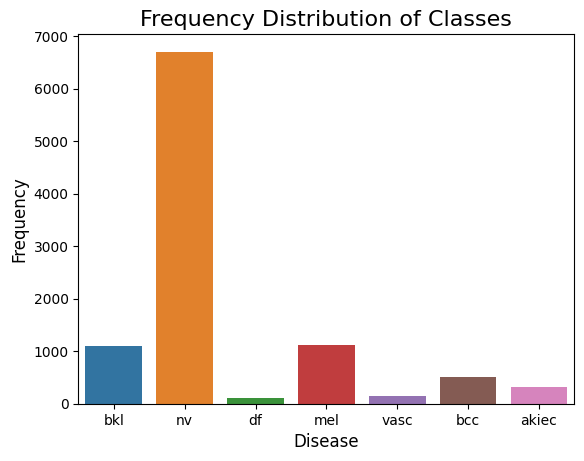

In [7]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

# Distribution of Disease over Gender

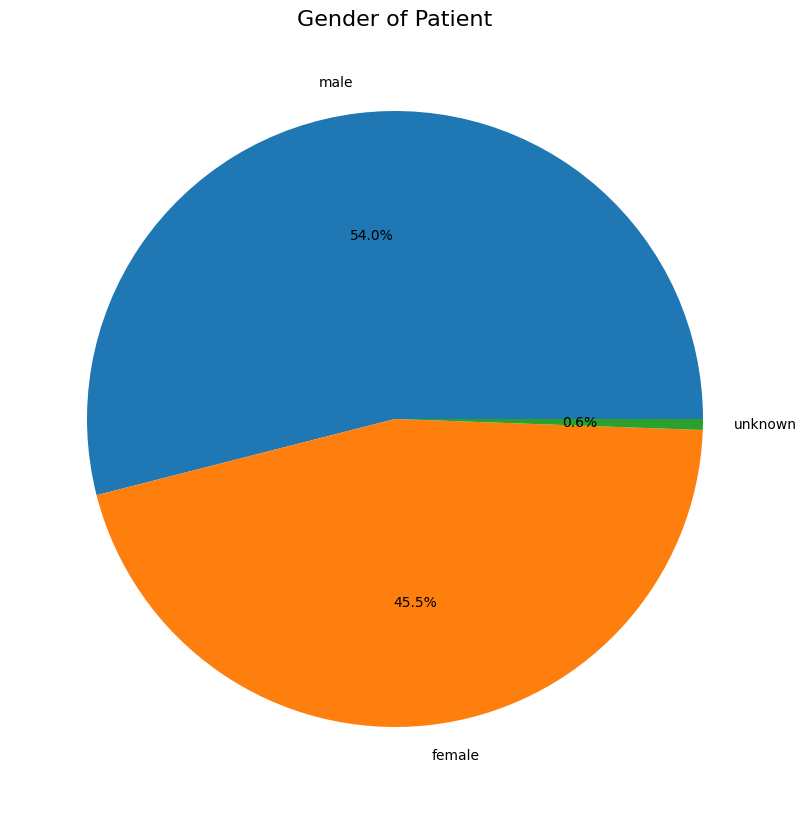

In [8]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)
plt.show()

# Histogram of Age of Patients

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


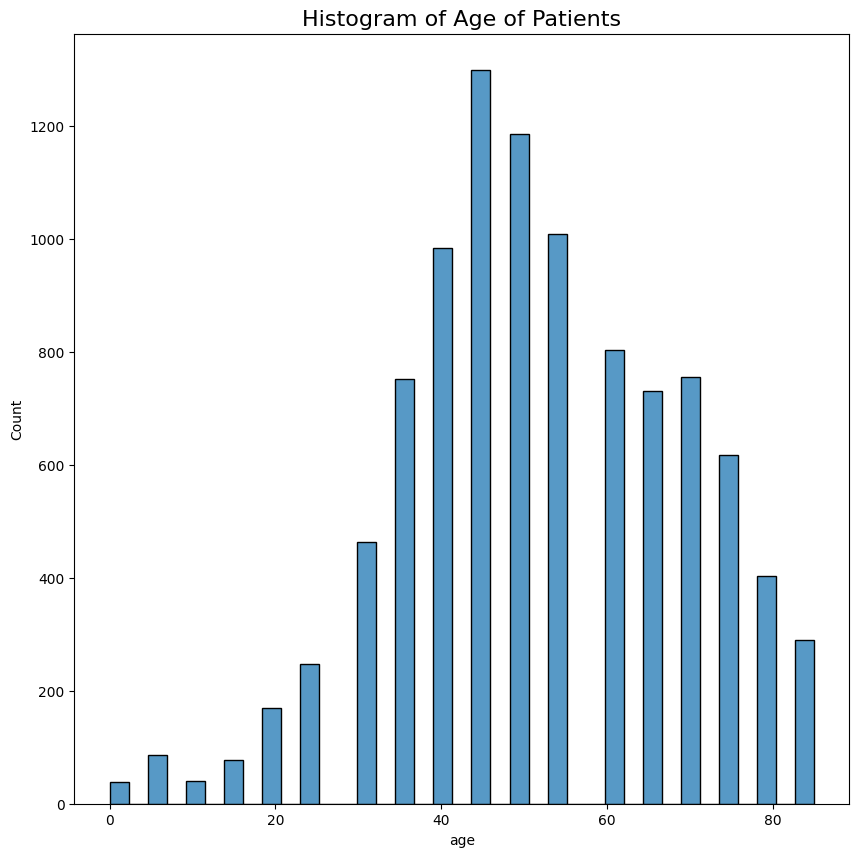

In [9]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)
plt.show()

# Location of disease over Gender

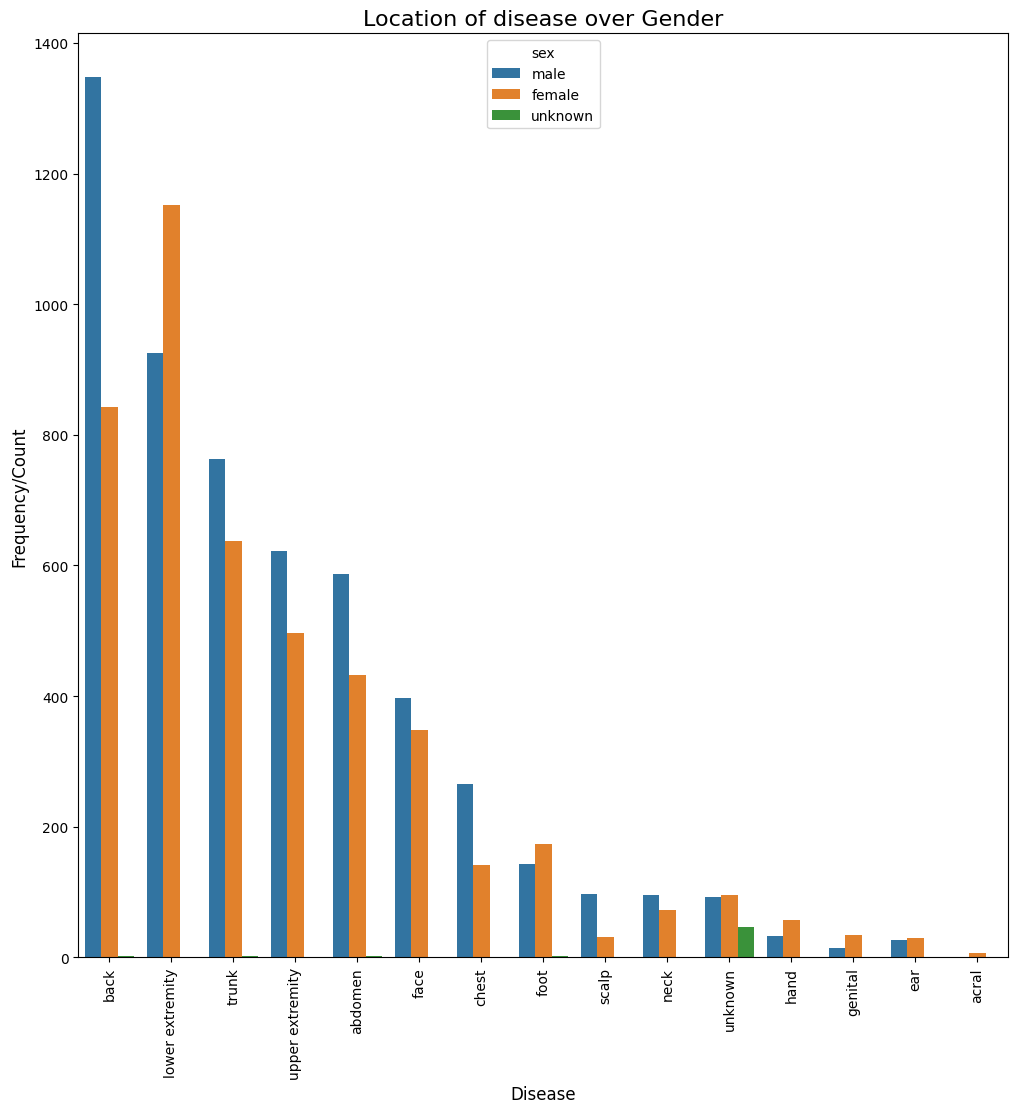

In [10]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)
plt.show()

# Oversampling
**To overcome class imbalace**

In [11]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [12]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [13]:
print('Shape of Y :',y.shape)

Shape of Y : (46935,)


# Standardization and Splitting Data

In [14]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# Custom Model

In [15]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec,Input,BatchNormalization,MaxPooling2D,concatenate,Activation,Dropout
import keras.layers as kl
import tensorflow as tf
from tensorflow.keras import Model



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [16]:
 MainInput=Input(shape=(28, 28, 3))

 conv=(Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(MainInput))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=64,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))

 conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

 conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))

 conv=(MaxPooling2D()(conv))


 conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))

 conv=(MaxPooling2D()(conv))

 conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))

 attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
 attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
 conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

 conv = concatenate([conv,attention_layer])
 conv=Activation("relu")(conv)
 conv= Dropout(0.5)(conv)

 conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))
 conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
 conv=(BatchNormalization()(conv))

 conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

 conv=(Flatten()(conv))
 conv=(Dense(4096,activation="relu")(conv))
 conv=(Dense(4096,activation="relu")(conv))
 conv=(Dense(7, activation="softmax")(conv))

In [17]:
 from tensorflow.keras.models import Model
 model = Model(inputs=MainInput, outputs=conv)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     16,512 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 256) │    590,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 7, 7, 256) │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 256) │          0 │ batch_normalizat

 Total params: 31,193,431 (118.99 MB)

 Trainable params: 31,184,983 (118.96 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [19]:
from tensorflow.keras.applications import EfficientNetB0,ResNet50,MobileNetV2,ResNet101
from tensorflow.keras import layers

inputs = layers.Input(shape=(28, 28, 3))
model = ResNet101(include_top=False, input_tensor=inputs, weights="imagenet")
model.trainable = False

# Rebuild top
conv = MaxPooling2D(pool_size=(2, 2),padding="same")(model.output)
conv = (BatchNormalization()(conv))


attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv=Activation("relu")(conv)
conv= Dropout(0.5)(conv)

conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(7, activation="softmax")(conv))

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
from tensorflow.keras.models import Model
model = Model(inputs=inputs, outputs=conv,name="ResNet101")
model.summary()

Model: "ResNet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 34, 34, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 14, 14,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 14, 14,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 14, 14,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 16, 16,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 7, 7, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 7, 7, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 7, 7, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 7, 7, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 7, 7, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 7, 7, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 7, 7, 256) │      1,024 │ conv2_block1_3_c

 Total params: 83,376,023 (318.05 MB)

 Trainable params: 40,710,679 (155.30 MB)

 Non-trainable params: 42,665,344 (162.76 MB)

# Model Training

In [21]:
 model = Sequential()
 model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
 model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
 model.add(MaxPool2D(pool_size = (2,2)))
 model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
 model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
 model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
 model.add(Flatten())
 model.add(Dense(64, activation='relu'))
 model.add(Dense(32, activation='relu'))
 model.add(Dense(7, activation='softmax'))
 model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,663 (713.53 KB)

 Trainable params: 182,663 (713.53 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [23]:
Y_train.shape

(37548,)

In [24]:
 model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
               metrics = ['accuracy'])
 history = model.fit(X_train,
                     Y_train,
                     validation_split=0.2,
                     batch_size = 128,
                     epochs = 20,
                     callbacks=[callback])
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.3,
                    batch_size = 128,
                    epochs = 100,
                    callbacks=[callback])

Epoch 1/20


2024-08-05 11:47:28.206389: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.28693, expected 2.63109
2024-08-05 11:47:28.206445: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.37105, expected 2.71521
2024-08-05 11:47:28.206456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.69062, expected 3.03478
2024-08-05 11:47:28.206464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.53917, expected 2.88333
2024-08-05 11:47:28.206472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.81121, expected 3.15537
2024-08-05 11:47:28.206481: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.71916, expected 2.06332
2024-08-05 11:47:28.206489: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.69741, expected 3.04157
2024-08-05 11:47:28.206498: E external/local_xla/xla/se

 35/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2750 - loss: 1.7819

I0000 00:00:1722858450.810480      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722858450.832131      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4430 - loss: 1.4111

2024-08-05 11:47:32.135109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.47348, expected 3.62048
2024-08-05 11:47:32.135178: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.42029, expected 3.5673
2024-08-05 11:47:32.135193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.82036, expected 2.96736
2024-08-05 11:47:32.135206: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.19279, expected 3.33979
2024-08-05 11:47:32.135224: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.53777, expected 3.68477
2024-08-05 11:47:32.135238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.92035, expected 4.06735
2024-08-05 11:47:32.135248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.96136, expected 4.10837
2024-08-05 11:47:32.135259: E external/local_xla/xla/ser

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4478 - loss: 1.3999

W0000 00:00:1722858454.919247      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4483 - loss: 1.3988 - val_accuracy: 0.6176 - val_loss: 1.0435
Epoch 2/20
224/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7248 - loss: 0.7305
Epoch 2: saving model to best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7270 - loss: 0.7250 - val_accuracy: 0.7590 - val_loss: 0.6544
Epoch 3/20
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.4390
Epoch 3: saving model to best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8400 - loss: 0.4363 - val_accuracy: 0.7631 - val_loss: 0.6678
Epoch 4/20
226/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8295 - loss: 0.4735
Epoch 4: saving model to best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8314 - loss: 0.4682 - val_accuracy: 0.8366 - val_loss: 0.4430
Epoch 5/20
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8811 - loss: 0.3378
Epoch 5: saving m

W0000 00:00:1722858483.523129      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/206 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9841 - loss: 0.0479

2024-08-05 11:48:04.676322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 784: 3.3825, expected 2.47802
2024-08-05 11:48:04.676382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 785: 5.19146, expected 4.28699
2024-08-05 11:48:04.676391: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786: 4.63927, expected 3.73479
2024-08-05 11:48:04.676399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 787: 4.94491, expected 4.04043
2024-08-05 11:48:04.676407: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 788: 5.12802, expected 4.22355
2024-08-05 11:48:04.676415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 789: 5.54517, expected 4.64069
2024-08-05 11:48:04.676423: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 790: 5.03638, expected 4.13191
2024-08-05 11:48:04.676431: E external/loc

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9841 - loss: 0.0479

W0000 00:00:1722858487.465316      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9842 - loss: 0.0479 - val_accuracy: 0.9639 - val_loss: 0.1573
Epoch 2/100
204/206 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9773 - loss: 0.0644
Epoch 2: saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9774 - loss: 0.0641 - val_accuracy: 0.9293 - val_loss: 0.3223
Epoch 3/100
202/206 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9148 - loss: 0.3020
Epoch 3: saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9159 - loss: 0.2981 - val_accuracy: 0.9057 - val_loss: 0.5379
Epoch 4/100
203/206 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9054 - loss: 0.3569
Epoch 4: saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9064 - loss: 0.3529 - val_accuracy: 0.8925 - val_loss: 0.3803
Epoch 5/100
202/206 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9070 - loss: 0.3185
Epoch 5: savin

# Plot Accuracy and Loss

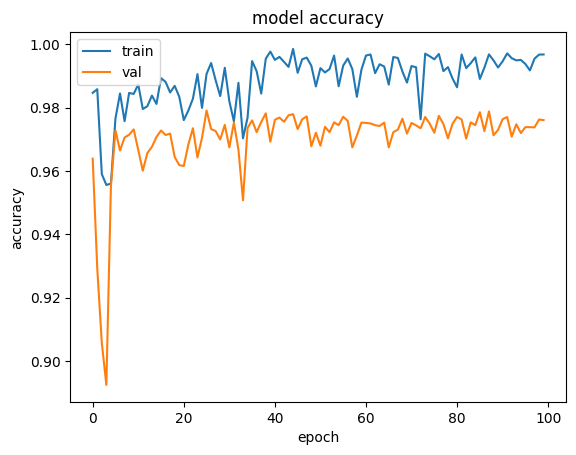

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

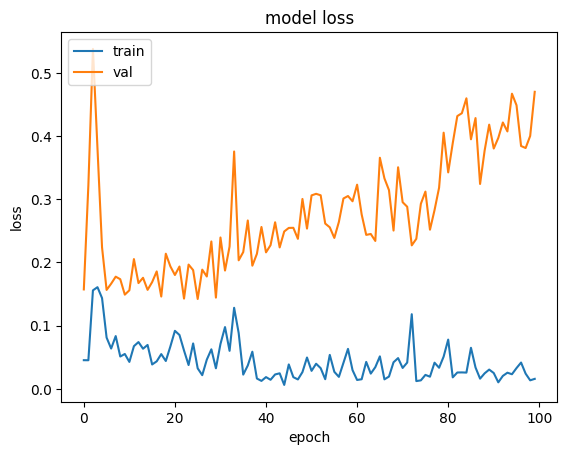

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.load_weights('best_model.keras')

In [28]:
classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


In [29]:
from sklearn.metrics import confusion_matrix , classification_report

In [30]:
y_true = np.array(Y_test)
y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
print(y_true)
print(y_pred)

2024-08-05 11:50:12.433141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.13766, expected 3.32655
2024-08-05 11:50:12.433199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.34, expected 4.52888
2024-08-05 11:50:12.433209: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.1601, expected 3.34898
2024-08-05 11:50:12.433218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.16167, expected 4.35055
2024-08-05 11:50:12.433225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.26013, expected 4.44902
2024-08-05 11:50:12.433233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.10789, expected 4.29677
2024-08-05 11:50:12.433241: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.789, expected 3.97789
2024-08-05 11:50:12.433249: E external/local_xla/xla/service/

272/294 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-08-05 11:50:13.581593: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 784: 3.89067, expected 3.151
2024-08-05 11:50:13.581649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786: 4.87851, expected 4.13884
2024-08-05 11:50:13.581658: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 787: 5.08924, expected 4.34956
2024-08-05 11:50:13.581666: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 788: 5.69716, expected 4.95749
2024-08-05 11:50:13.581674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 789: 5.7147, expected 4.97503
2024-08-05 11:50:13.581682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 790: 4.89133, expected 4.15166
2024-08-05 11:50:13.581690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 791: 5.60215, expected 4.86248
2024-08-05 11:50:13.581698: E external/local

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
[5 1 4 ... 2 6 0]
[5 1 4 ... 6 6 1]


In [31]:
pred=model.predict(X_test)
pred

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.00000000e+00, 0.00000000e+00, 5.35259479e-23, ...,
        2.36802436e-24, 1.00000000e+00, 1.21352364e-28],
       [2.74282093e-06, 9.99996781e-01, 1.09948384e-09, ...,
        1.27785867e-07, 2.41505642e-29, 3.49465552e-07],
       [5.80003019e-20, 2.41458860e-18, 1.03637876e-10, ...,
        9.99999762e-01, 2.46664018e-18, 2.45556151e-07],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 9.99362409e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.37589779e-04]], dtype=float32)

In [32]:
classes_labels

[4, 6, 2, 1, 5, 0, 3]

In [33]:
report = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1359
           1       0.99      1.00      0.99      1318
           2       0.94      0.97      0.96      1262
           3       1.00      1.00      1.00      1351
           4       0.97      0.85      0.91      1374
           5       1.00      1.00      1.00      1358
           6       0.91      0.98      0.95      1365

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387



In [34]:
cm=confusion_matrix(y_true,y_pred,labels=classes_labels)
print(confusion_matrix(y_true,y_pred,labels=classes_labels))

[[1170  113   68   14    3    4    2]
 [  13 1344    6    1    0    1    0]
 [  20   12 1229    1    0    0    0]
 [   0    0    0 1318    0    0    0]
 [   0    2    0    1 1355    0    0]
 [   0    2    0    1    0 1356    0]
 [   0    0    0    0    0    0 1351]]


<Axes: >

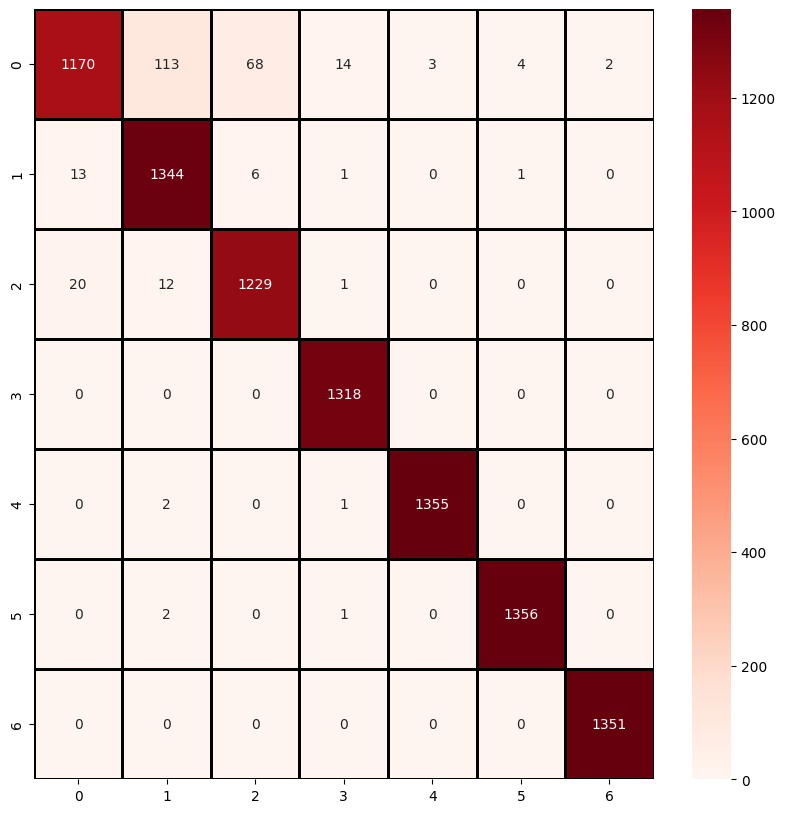

In [35]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Model Testing

In [36]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 1s - 4ms/step - accuracy: 0.9719 - loss: 2.4896


# Model Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


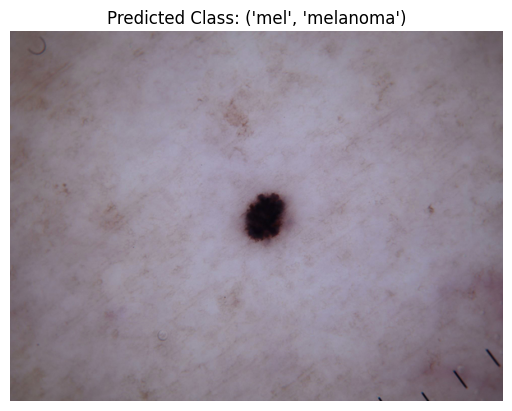

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


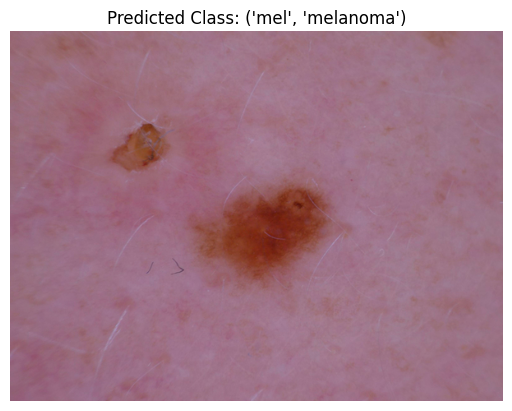

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


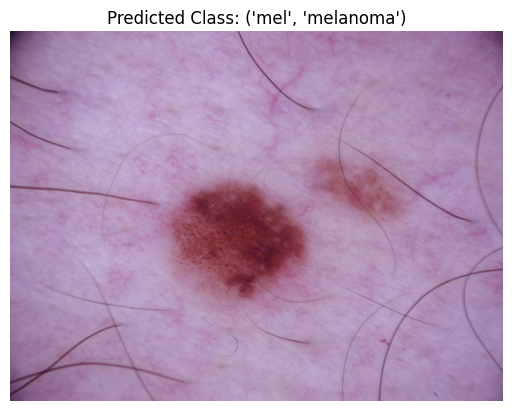

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


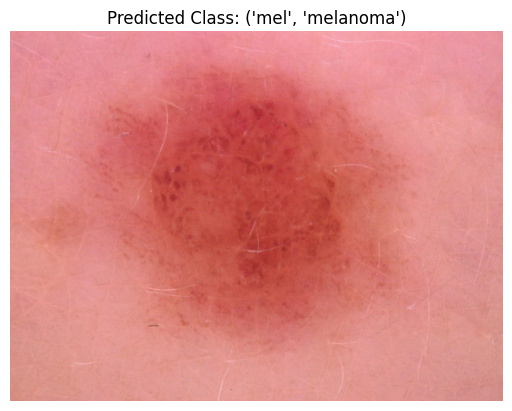

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


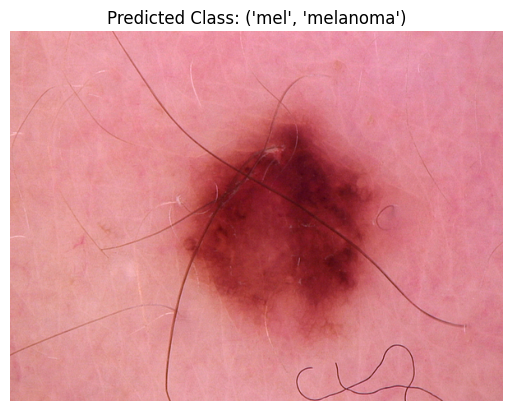

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


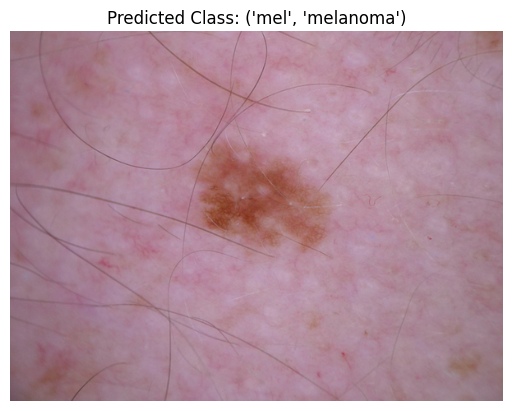

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


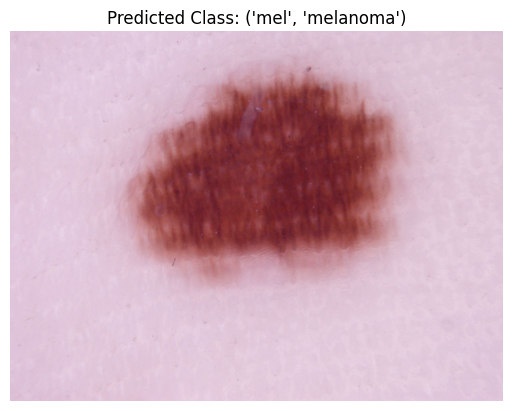

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


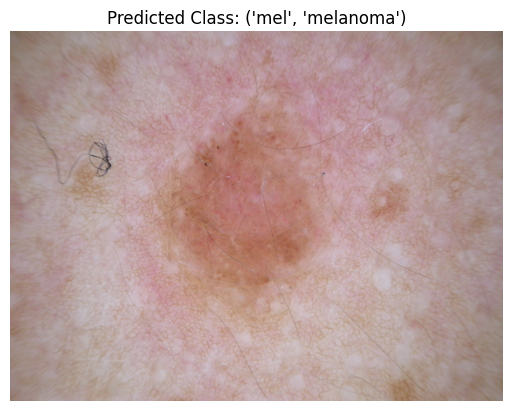

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


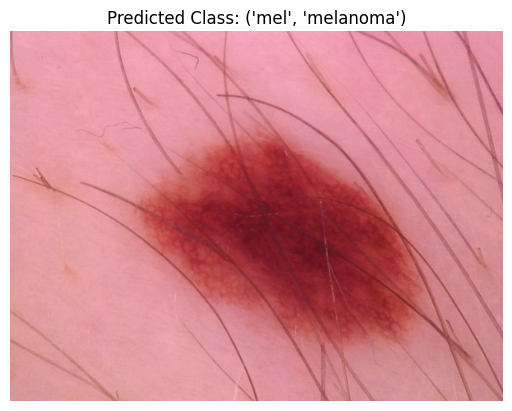

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


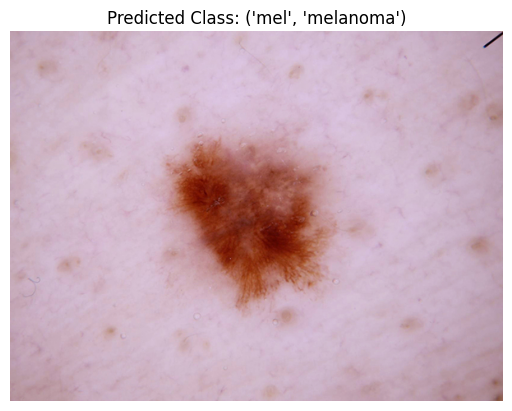

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted probabilities: [0. 0. 0. 0. 0. 0. 1.]
Predicted class index: 6, class name: ('mel', 'melanoma'), max probability: 1.0


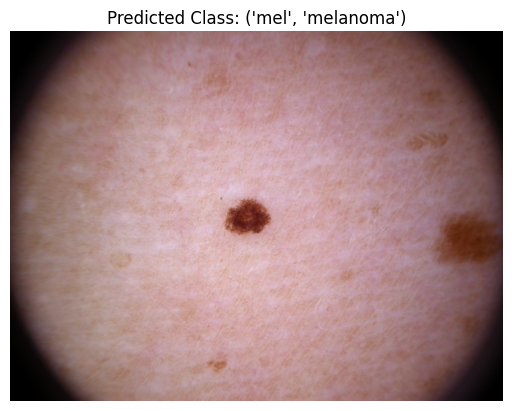

In [37]:
import os
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('best_model.keras')
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}
srcdir = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
count = 0

for temp in os.listdir(srcdir):
    img_path = os.path.join(srcdir, temp)
    img = cv2.imread(img_path)
    
    if img is not None:
        # Resize the image to the required input size of the model
        img_resized = cv2.resize(img, (28, 28))
        
        # Normalize the image
        img_normalized = img_resized / 255.0
        
        # Predict the class
        result = model.predict(img_normalized.reshape(1, 28, 28, 3))
        print(f'Predicted probabilities: {result[0]}')  # Debugging line
        
        max_prob = max(result[0])
        class_ind = list(result[0]).index(max_prob)
        class_name = classes[class_ind]
        
        print(f'Predicted class index: {class_ind}, class name: {class_name}, max probability: {max_prob}')  # Debugging line
        
        # Display the image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Predicted Class: {class_name}')
        plt.axis('off')
        plt.show()
        
        count += 1
        if count > 10:
            break
    else:
        print(f'Failed to read image: {img_path}')